In [1]:
import ROOT

# silence most of the roofit message (bug in ROOT saturate jupyter stream)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.NumIntegration)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.Fitting)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.Minimization)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.InputArguments)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.Eval)
ROOT.RooMsgService.instance().setGlobalKillBelow(ROOT.RooFit.ERROR)

ROOT.enableJSVis()

Welcome to JupyROOT 6.10/06


Add some sugar. With this you will get exceptions instead of null pointers errors. Just execute and pass over.

In [2]:
def safe_factory(func):
    def wrapper(self, *args):
        result = func(self, *args)
        if not result:
            raise ValueError('invalid factory input "%s"' % args)
        return result
    return wrapper

ROOT.RooWorkspace.factory = safe_factory(ROOT.RooWorkspace.factory)

def safe_decorator(func):
    def wrapper(self, *args):
        result = func(self, *args)
        if not result:
            raise ValueError('cannot find %s' % args[0])
        return result
    return wrapper

ROOT.RooWorkspace.data = safe_decorator(ROOT.RooWorkspace.data)
ROOT.RooWorkspace.obj = safe_decorator(ROOT.RooWorkspace.obj)
ROOT.RooWorkspace.var = safe_decorator(ROOT.RooWorkspace.var)
ROOT.RooWorkspace.pdf = safe_decorator(ROOT.RooWorkspace.pdf)

def loop_iterator(iterator):
  object = iterator.Next()
  while object:
    yield object
    object = iterator.Next()

def iter_collection(rooAbsCollection):
  iterator = rooAbsCollection.createIterator()
  return loop_iterator(iterator)

def show_graph(node):
    """
    display the computational graph relative to a statistical model
    """
    from IPython.display import HTML, IFrame, Image, SVG, Latex
    import re
    import os
    prefix = "graph_%s" % node.GetName()
    node.graphVizTree("%s.dot" % prefix)
    os.system("dot -Tsvg {0}.dot > {0}.svg; rm {0}.dot".format(prefix))
    s = SVG("{}.svg".format(prefix))
    s.data = re.sub(r'width="[0-9]+pt"', r'width="90%"', s.data)
    s.data = re.sub(r'height="[0-9]+pt"', r'height=""', s.data);
    return s

def import_ws(ws, obj):
    # dear ROOT: `import` is a keyword in python
    getattr(ws, 'import')(obj)
    
# ROOT.RooDataSet.setDefaultStorageType(ROOT.RooAbsData.Tree)

In [13]:
# define some constants, values are in pb(^-1) and GeV
WS_NAME = 'ws'
PRESENT_LUMINOSITY = 50E3 
XSECTION_X_BR_SM = 0.1 
VISIBLE_XSECTION_BKG = 4.5  # the background will be fitted on data, here just an reasonable number

ws = ROOT.RooWorkspace(WS_NAME)            # create the workspace object
mass = ws.factory("mass[100, 160]")        # observable: invariant mass
# define the parameter of intereset: we will fit / set limits on the cross section
# discovery is based on the exclusion of cross section == 0
ws.factory("xsection_x_br[-0.1, 0.5]").setVal(XSECTION_X_BR_SM)  # pb
poi = xsection = ws.var("xsection_x_br")
ws.factory('nominal_efficiency[0.5]')
ws.factory('nominal_luminosity[50E3]')    
ws.factory('nominal_resolution[5]')        # nominal mass detector resolution at ~125 GeV

# relative uncertainties
ws.factory('sigma_luminosity[0.02]')       # luminosity uncertainty on the signal yield
ws.factory('sigma_efficiency[0.05]')       # efficiency uncertainty on the signal yield
ws.factory('sigma_resolution[0.05]')       # energy resolution uncertainty on the peak width
ws.factory('sigma_mH[0.003]')              # energy scale uncertainty on the peak position

# the background parameters (number of events and slope of the shape) are not know
# we are setting them to a reasonable values here, but we will set them to the best value
# from a signal+background fit on data
ws.factory('xsection_bkg[0, 100E3]').setVal(VISIBLE_XSECTION_BKG)
# parametrize the number of background events as a functinon of the luminosity so that
# we can do extrapolation to different luminosities
ws.factory('prod:nbkg(nominal_luminosity, xsection_bkg)')
ws.factory('bkg_slope[-0.03, -0.5, -0.001]')

# signal parameters
ws.factory("mH[125, 90, 150]").setConstant()   # mass of the resonance [GeV]
                                               # forget about natural width, dominated by det resolution

# signal peak position
ws.factory('expr:kpeak("1 + @0 * @1", {sigma_mH, theta_mH[0, -5, 5]})')
ws.factory('expr:peak("@0 * @1", {mH, kpeak})')   # peak position for signal
# signal width
ws.factory('expr:resolution("@0 * (1 + @1 * @2)", {nominal_resolution, sigma_resolution, theta_resolution[0, -5, 5]})')
# signal shape
signal = ws.factory("RooGaussian:signal_shape(mass, peak, resolution)")

# luminosity
ws.factory('expr:luminosity("@0 * (exp(@1 * @2))", {nominal_luminosity, sigma_luminosity, theta_luminosity[0, -5, 5]})')
# efficiency
ws.factory('expr:efficiency("@0 * (exp(@1 * @2))", {nominal_efficiency, sigma_efficiency, theta_efficiency[0, -5, 5]})')
# expected signal theory
ws.factory('prod:nsignal(luminosity, xsection_x_br, efficiency)')

# background shape
ws.factory("RooExponential:background_shape(mass, bkg_slope)")
# no uncertainty on background since it is fully data-driven

ws.factory("SUM:phys_pdf(nsignal * signal_shape, nbkg * background_shape)")
ws.factory("RooGaussian:constrain_peak(global_peak[0, -5, 5], theta_mH, 1)")
ws.factory("RooGaussian:constrain_resolution(global_resolution[0, -5, 5], theta_resolution, 1)")
ws.factory("RooGaussian:constrain_luminosity(global_luminosity[0, -5, 5], theta_luminosity, 1)")
ws.factory("RooGaussian:constrain_efficiency(global_efficiency[0, -5, 5], theta_efficiency, 1)")
ws.factory("PROD:constraints(constrain_peak, constrain_luminosity, constrain_resolution, constrain_efficiency)")

ws.defineSet('global_observables', ws.allVars().selectByName('global_*'))
ROOT.RooStats.SetAllConstant(ws.set('global_observables'))
ws.defineSet('pulls', ws.allVars().selectByName('theta_*'))
ws.defineSet('nuis', ws.set('pulls'))
nuis = ws.set('nuis')
nuis.add(ws.var('bkg_slope'))
nuis.add(ws.var('xsection_bkg'))

model = ws.factory("PROD:model(phys_pdf, constraints)")

# import real data from a TTree
f = ROOT.TFile.Open('real_data.root')
tree = f.Get("data")
data_unbinned = ROOT.RooDataSet('data_unbinned', 'real data unbinned',
                                ROOT.RooArgSet(mass),
                                ROOT.RooFit.Import(tree))
# since we have a lot of data it is more convenient to use a binned version of the data
# (and of the likelihood, RooFit will manage that)
data_binned = ROOT.RooDataHist("data_binned", "binned real data", ROOT.RooArgSet(mass), data_unbinned)
# since we don't know where the execess keep mH free just for this fit
ws.var('mH').setConstant(False)
print "before fit"
print "=" * 80
print "bkg vis xsection: ", ws.var('xsection_bkg').getVal()
print "bkg slope: ", ws.var('bkg_slope').getVal()
model.fitTo(data_binned, ROOT.RooFit.PrintLevel(-1))    # fit on data: only to get background parameters
print "after fit"
print "=" * 80
print "bkg vis xsection: ", ws.var('xsection_bkg').getVal()
print "bkg slope: ", ws.var('bkg_slope').getVal()
ws.var('mH').setVal(125)           # reset mH value to our test value
ws.var('mH').setConstant(True)     # we test each mH hypothesis one by one with separate tests

# in case we want to go back to this values, save a snapshot of all the variables
ws.saveSnapshot('data_fit', ws.allVars())

# create the model configs
# model config are needed to specify the meaning of the variables from the
# interference point of view: what are the observables, the nuisance parameters, ...
# start from a generic model config
model_config = ROOT.RooStats.ModelConfig('model_config', ws)
model_config.SetPdf('model')
model_config.SetParametersOfInterest('xsection_x_br')
model_config.SetNuisanceParameters(ws.set("nuis"))
model_config.SetGlobalObservables(ws.allVars().selectByName("global_*"))
model_config.SetObservables('mass')
import_ws(ws, model_config)

# create a model config with nominal signal
sb_model_config = model_config.Clone()
sb_model_config.SetName("S+B Model");      
xsection.setVal(XSECTION_X_BR_SM)
sb_model_config.SetSnapshot(ROOT.RooArgSet(xsection))

# create a model config without signal
b_model_config = sb_model_config.Clone()
b_model_config.SetName("B Model")
poi.setVal(0)
b_model_config.SetSnapshot(ROOT.RooArgSet(poi))


poi.setVal(XSECTION_X_BR_SM)
data_toy_unbinned = model.generate(model_config.GetObservables())
data_toy_binned = model.generateBinned(model_config.GetObservables())
data_asimov = model.generateBinned(model_config.GetObservables(), ROOT.RooFit.ExpectedData())
data_toy_binned.SetName('data_toy_binned')
data_asimov.SetName('data_asimov')

import_ws(ws, data_toy_binned)
import_ws(ws, data_asimov)

ws.writeToFile('workspace.root')

before fit
bkg vis xsection:  4.5
bkg slope:  -0.03
after fit
bkg vis xsection:  5.00427947972
bkg slope:  -0.0300629507721


False

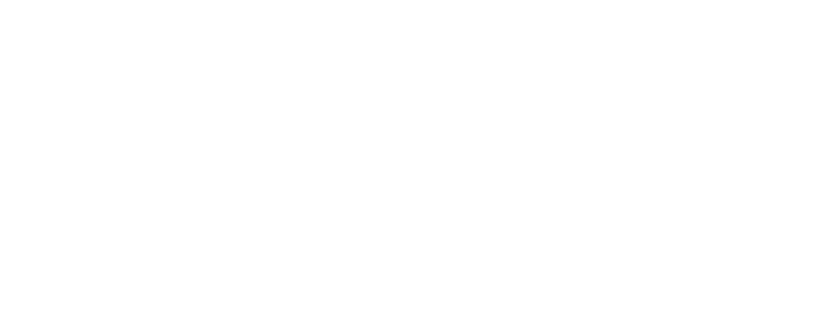

In [14]:
show_graph(ws.pdf('signal_shape'))

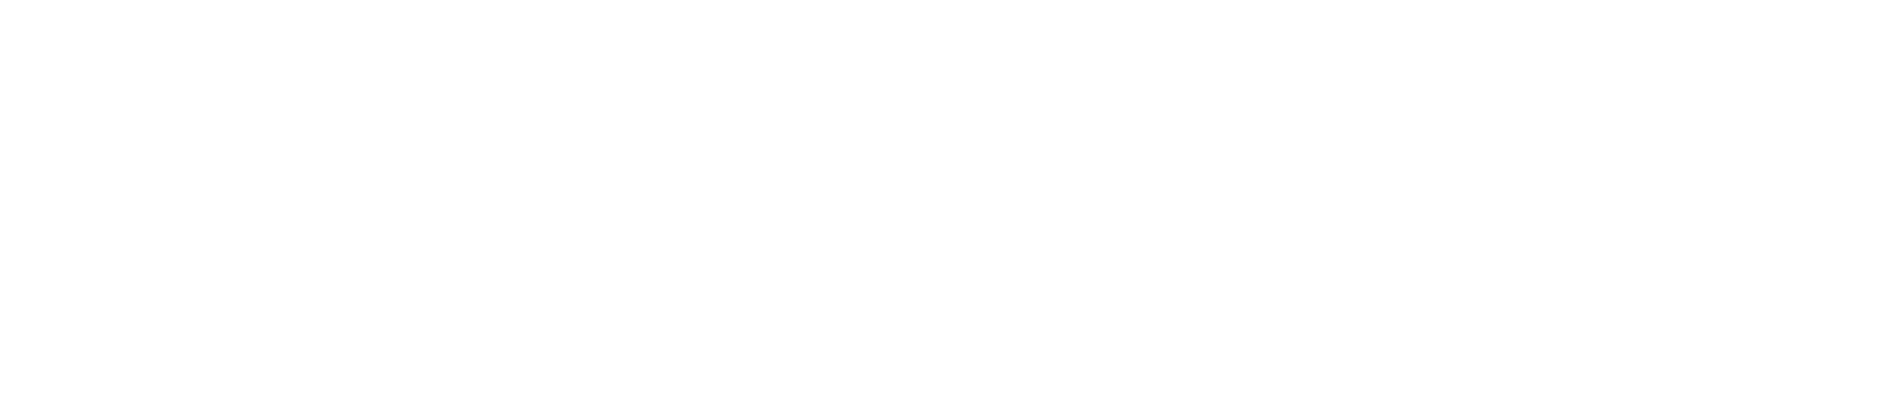

In [15]:
show_graph(ws.pdf('phys_pdf'))

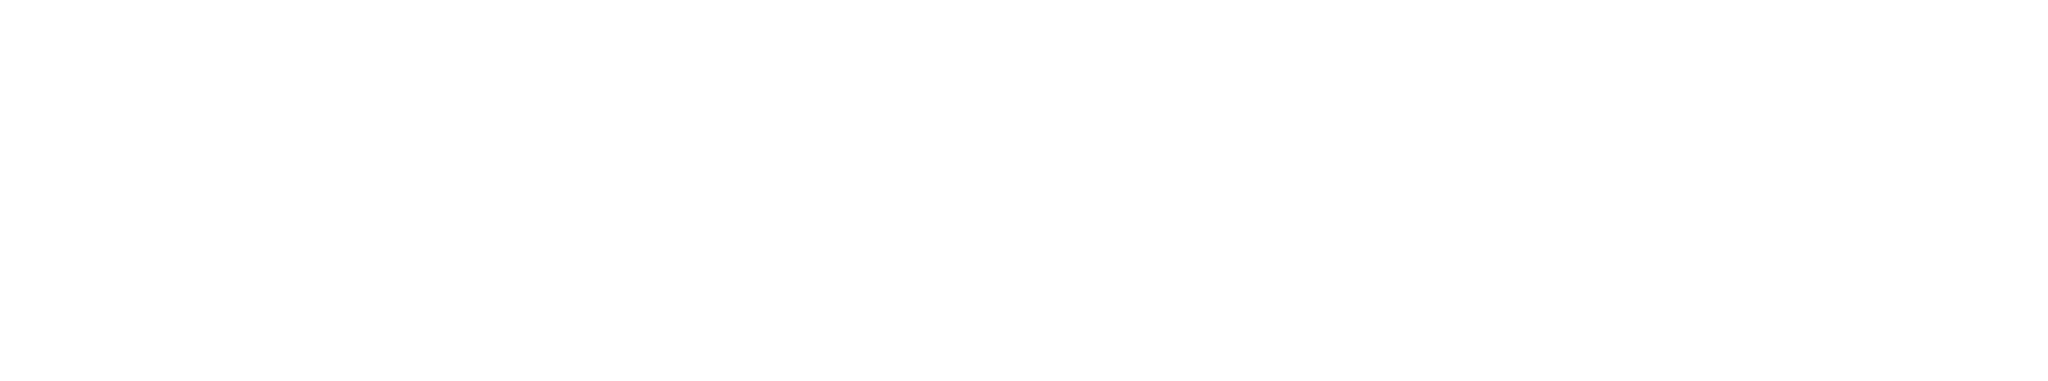

In [16]:
show_graph(model)

In [17]:
canvas = ROOT.TCanvas("", "", 800, 300)
effects = ['efficiency', 'luminosity', 'resolution']
canvas.DivideSquare(len(effects))
for i, effect in enumerate(effects, 1):
    canvas.cd(i)
    frame = ws.var('theta_%s' % effect).frame()
    ws.obj(effect).plotOn(frame)
    frame.Draw()
    canvas.cd(i).SetGrid()
canvas.Draw()

In [104]:
fit_result = model.fitTo(data_asimov,
                         ROOT.RooFit.Minos(),
                         ROOT.RooFit.PrintLevel(-1),
                         ROOT.RooFit.Save())
fit_result.Print("V")


  RooFitResult: minimized FCN value: -1.88586e+06, estimated distance to minimum: 1.80997e-05
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 MINOS=0 

    Constant Parameter    Value     
  --------------------  ------------
     global_efficiency    0.0000e+00
     global_luminosity    0.0000e+00
           global_peak    0.0000e+00
     global_resolution    0.0000e+00
                    mH    1.2500e+02
    nominal_efficiency    5.0000e-01
    nominal_luminosity    5.0000e+04
    nominal_resolution    5.0000e+00
      sigma_efficiency    5.0000e-02
      sigma_luminosity    2.0000e-02
              sigma_mH    3.0000e-03
      sigma_resolution    5.0000e-02

    Floating Parameter  InitialValue    FinalValue (+HiError,-LoError)    GblCorr.
  --------------------  ------------  ----------------------------------  --------
             bkg_slope   -3.0000e-02   -2.9996e-02 (+1.27e-04,-1.27e-04)  <none>
      the

In [116]:
mass_frame = mass.frame()
data_asimov.plotOn(mass_frame, ROOT.RooFit.Name('curve_data'))
model.plotOn(mass_frame, ROOT.RooFit.VisualizeError(fit_result, 3),
             ROOT.RooFit.Name('curve_signal_background_fit'))

model.plotOn(mass_frame, ROOT.RooFit.Components('background_shape'),
             ROOT.RooFit.LineStyle(ROOT.kDashed),
             ROOT.RooFit.Name('curve_background_component'))
canvas = ROOT.TCanvas()
mass_frame.Draw()
canvas.Draw()

In [121]:
canvas = ROOT.TCanvas()
pull_hist = mass_frame.pullHist('curve_data', 'curve_background_component')
pull_hist.Draw()
canvas.Draw()

In [97]:
print 'nsignal', ws.obj('nsignal').getVal()
print 'nbackground', ws.obj('nbkg').getVal()

2498.75896903
250000.045267


In [64]:
# print constant variables
ws.allVars().selectByAttrib("Constant", True).Print("V")

  1) RooRealVar:: nominal_efficiency = 0.5
  2) RooRealVar:: nominal_luminosity = 100000
  3) RooRealVar:: nominal_resolution = 5
  4) RooRealVar::   sigma_luminosity = 0.02
  5) RooRealVar::   sigma_efficiency = 0.05
  6) RooRealVar::   sigma_resolution = 0.05
  7) RooRealVar::           sigma_mH = 0.003
  8) RooRealVar::                 mH = 125
  9) RooRealVar::        global_peak = 0
 10) RooRealVar::  global_resolution = 0
 11) RooRealVar::  global_luminosity = 0
 12) RooRealVar::  global_efficiency = 0


In [65]:
# print non-constant variable (may be fitted)
ws.allVars().selectByAttrib("Constant", False).Print("V")

  1) RooRealVar::             mass = 120
  2) RooRealVar::    xsection_x_br = 0.100005 +/- (-0.00946896,0.00974134)
  3) RooRealVar::             nbkg = 600001 +/- (-861.223,874.397)
  4) RooRealVar::        bkg_slope = -0.0299962 +/- (-7.05315e-05,7.18905e-05)
  5) RooRealVar::         theta_mH = -0.00115631 +/- (-0.762288,0.757275)
  6) RooRealVar:: theta_resolution = 0.0115203 +/- (-0.901147,0.872138)
  7) RooRealVar:: theta_luminosity = 0.000161931 +/- (-1.00012,0.9999)
  8) RooRealVar:: theta_efficiency = -0.00580489 +/- (-0.99418,1.00586)


In [32]:
model_config.GetNuisanceParameters().Print("V")

  1) RooRealVar::         theta_mH = -0.001896 +/- 0.330456
  2) RooRealVar::      theta_width = 0.011512 +/- 0.882831
  3) RooRealVar:: theta_luminosity = 0.000233857 +/- 0.993956
  4) RooRealVar:: theta_efficiency = -0.00562966 +/- 0.998189
  5) RooRealVar::              tau = -0.0299962 +/- 7.13162e-05
  6) RooRealVar::             nbkg = 600001 +/- 868.134


## Check the pulls

It is important to check that the nuisance parameters are compatible with 0, otherwise it means that there is a tension between our channel and the axiliary measurement (efficiency measurent, energy scale, ...). Usually channels are not sensitive to constrain systematic effects (otherwise these would have been used to do the measurement).

In this case the pull of the width and of the energy scale is quite constrained, so our channel could provide infomation on these systematic. The problem is that we are assuming to know the mass and the width, which is not true.

In [33]:
ws.set('pulls').Print("V")

  1) RooRealVar::         theta_mH = -0.001896 +/- 0.330456
  2) RooRealVar::      theta_width = 0.011512 +/- 0.882831
  3) RooRealVar:: theta_luminosity = 0.000233857 +/- 0.993956
  4) RooRealVar:: theta_efficiency = -0.00562966 +/- 0.998189


In [16]:
canvas = ROOT.TCanvas()

poi = model_config.GetParametersOfInterest().first()  # the cross section
# do an initial fit
model.fitTo(data_asimov, ROOT.RooFit.PrintLevel(-1))

# create a profile likelihood calculator (it just compute the profile
# likelihood, can perform a scan and find a confidence interval
pl = ROOT.RooStats.ProfileLikelihoodCalculator(data_asimov, model_config)
pl.SetConfidenceLevel(0.683)  # usual 1 sigma gaussian
interval = pl.GetInterval()   # the real work
lowerLimit = interval.LowerLimit(poi)
upperLimit = interval.UpperLimit(poi)
print "[lower, upper] limit: [%.3f, %.3f]" % (lowerLimit, upperLimit)
plot = ROOT.RooStats.LikelihoodIntervalPlot(interval)
plot.Draw("tf1")

model.fitTo(data_asimov, ROOT.RooFit.PrintLevel(-1))
ROOT.RooStats.SetAllConstant(ws.set('pulls'))
pl_nosys = ROOT.RooStats.ProfileLikelihoodCalculator(data_asimov, model_config)
pl_nosys.SetConfidenceLevel(0.683)  # usual 1 sigma gaussian
interval_nosys = pl_nosys.GetInterval()
lowerLimit_nosys = interval_nosys.LowerLimit(poi)
upperLimit_nosys = interval_nosys.UpperLimit(poi)
print "[lower, upper] limit: [%.3f, %.3f]" % (lowerLimit_nosys, upperLimit_nosys)
plot_nosys = ROOT.RooStats.LikelihoodIntervalPlot(interval_nosys)
plot_nosys.Draw("tf1 same")
ROOT.RooStats.SetAllConstant(ws.set('pulls'), False)


canvas.Draw()

[lower, upper] limit: [0.096, 0.104]
[lower, upper] limit: [0.098, 0.102]


ProfileLikelihoodCalculator is not very used since it is not very flexible: difficult to tweak the profile likelihood scan plot, not possible to parallelize the computation of the likelihood for each point of the scan... Usually people do a manual scan, usually splitting the computation on different machines.

Write a loop to do the scan using the profile likelihood object

In [17]:
nll = model.createNLL(data_asimov)
nll.createProfile(model_config.GetParametersOfInterest())

# write the loop here changing every time the value of the poi

poi = model_config.GetParametersOfInterest().first()
poi.setVal(90)
print nll.getVal()  # this is the value of the profile likelihood for a particular value of the poi

# normalize the result to the minimum, since we want the profile likelihood *ratio*

# plot it

# repeat with no systematics (fixing NP to best values)

-5033726.78149


In [18]:
data_toy_binned = model.generateBinned(model_config.GetObservables())
result = model.fitTo(data_asimov,
                     ROOT.RooFit.PrintLevel(-1),
                     ROOT.RooFit.Save())
result.Print("V")


  RooFitResult: minimized FCN value: -5.05248e+06, estimated distance to minimum: 3.12771e-05
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Constant Parameter    Value     
  --------------------  ------------
     global_efficiency    0.0000e+00
     global_luminosity    0.0000e+00
           global_peak    0.0000e+00
          global_width    0.0000e+00
                    mH    1.2500e+02
    nominal_efficiency    5.0000e-01
    nominal_luminosity    1.0000e+05
         nominal_width    5.0000e+00
      sigma_efficiency    5.0000e-02
      sigma_luminosity    2.0000e-02
              sigma_mH    1.0000e-02
           sigma_width    5.0000e-02

    Floating Parameter  InitialValue    FinalValue +/-  Error     GblCorr.
  --------------------  ------------  --------------------------  --------
                  nbkg    5.9899e+05    6.0001e+05 +/-  9.03e+02  <none>
                   tau   -3.0077e-02   -2